# Part 2: Hardware Demo
## Outline
1. RPC server and client
<br>
2. Signal generation and oscilloscope measurement
<br>
2.1 Pulse generation
<br>
2.2 Gate generation
<br>
2.3 Circuit generation
<br>
3. Loopback test
<br>
4. Readout emulator and GMM fitting

In [1]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as cfg
import numpy as np
import matplotlib.pyplot as plt

## Load Configs and Define Circuit

Using the chipcalibration repository, load all three configs:
<br>
a. FPGA config: this has timing information for the scheduler
<br>
b. Channel configs: firmware channel mapping + configuration, see [Understanding Channel Configuration](https://gitlab.com/LBL-QubiC/software/-/wikis/Understanding-Channel-Configuration) for details
<br>
c. QChip object: contains calibrated gates + readout

In [2]:
chipname = 'X4Y2'
fpga_config, qchip, channel_configs = cfg.load_configs(chipname)

Define a circuit at the pulse-level. For details on the QubiC circuit format and supported operations, see [compiler.py](https://gitlab.com/LBL-QubiC/distributed_processor/-/blob/master/python/distproc/compiler.py).

In [3]:
circuit_1 = [
    
    # play a pi/2 pulse on Q0
    {'name': 'pulse', 'phase': 0, 'freq': 75138775, 'amp': 0.99, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q2.qdrv'} 
    
    # play a pi pulse on Q1
    #{'name': 'pulse', 'phase': 0, 'freq': 44383311, 'amp': 0.95, 'twidth': 4.8e-08,
    # 'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
    # 'dest': 'Q1.qdrv'}

]

Define a circuit with calibrated gates / parameters.

In [4]:
circuit_2 = [# !!!qubit freq for scope!!! nyquist zone !!!
    
    # play two consecutive pi/2 pulses on Q0
    {'name': 'X90', 'qubit': 'Q0'},
    {'name': 'X90', 'qubit': 'Q0'},
    
    # schedule barrier
    {'name': 'barrier', 'qubit': ['Q0','Q1']},
    
    # play two pi/2 pulses on Q0 and Q1 simultaneously
    {'name': 'X90', 'qubit': 'Q0'},
    {'name': 'X90', 'qubit': 'Q1'},   

    # schedule barrier
    {'name': 'barrier', 'qubit': ['Q0','Q1']},
    
    # play a CNOT gate on Q1 and Q0
    {'name': 'CNOT', 'qubit': ['Q1','Q0']}
    
]

Define a quantum circuit.

In [5]:
circuit_3 = [
    
    # allow qubit to decay to 0 state between shots
    {'name': 'delay', 't': 500.e-6}, 
    
    # set Q2 state to |1>
    {'name': 'X90', 'qubit': 'Q2'},
    {'name': 'X90', 'qubit': 'Q2'},
    
    # set Q3 to a state on the equator 
    {'name': 'X90', 'qubit': 'Q3'},
    
    # schedule barrier ensures that both readouts start after the pulses
    {'name': 'barrier', 'qubit': ['Q2', 'Q3']},
    
    # play readout gates for measurement
    {'name': 'read', 'qubit': 'Q2'},
    {'name': 'read', 'qubit': 'Q3'}

]

In [24]:
circuit_0 = [
    #{'name': 'delay', 't': 500.e-9}, 
    {'name': 'read', 'qubit': 'Q3', 'modi':{(0, 'amp'): 0.99}}
    #{'name': 'pulse', 'phase': 0, 'freq': 6.69e9, 'amp': 0.99, 'twidth': 2.4e-08, 'env': 'cw', 'dest': 'Q3.rdrv'}
    #{'name': 'X90', 'qubit': 'Q1', 'modi':{(0, 'amp'): 0.99, (0, 'freq'): 6699863279.32428}},
    #{'name': 'X90', 'qubit': 'Q2', 'modi':{(0, 'amp'): 0.99, (0, 'freq'): 6699863279.32428}},
    #{'name': 'X90', 'qubit': 'Q3', 'modi':{(0, 'amp'): 0.99, (0, 'freq'): 6699863279.32428}}
]

## Compile and Assemble

Compile the program. The output of the compile stage is a distributed processor assembly program, which consists of initialization / termination statements, as well as a list of scheduled pulses for each core.

In [27]:
compiled_prog = tc.run_compile_stage(circuit_0, fpga_config, qchip)
#circuit_2,circuit_3
#compiled_prog.program

Run the assembler to convert the above program into machine code that we can load onto the FPGA.

In [30]:
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)

## Connect to Server and Run Circuit

Now that we've defined our circuit and compiled it to machine code, we can submit it to the ZCU216 and run it.

Instantiate the runner client.

In [33]:
runner = rc.CircuitRunnerClient(ip='192.168.0.13', port=9095)

Submit the circuit to the server, and collect 1000 shots.

In [34]:
for i in range(1000):
    s11 = runner.run_circuit_batch([raw_asm], 1000, delay_per_shot=0)

Fault: <Fault 1: "<class 'AttributeError'>:'int' object has no attribute 'reshape'">

A dictionary of downconverted + integrated complex (IQ) values is returned for each loaded channel. Here, we're using both Q1 and Q2, so we get back data for channel '4' (Q1), and channel '1' (Q2)

In [11]:
s11.keys()

dict_keys(['3'])

Text(0.5, 1.0, 'Q3')

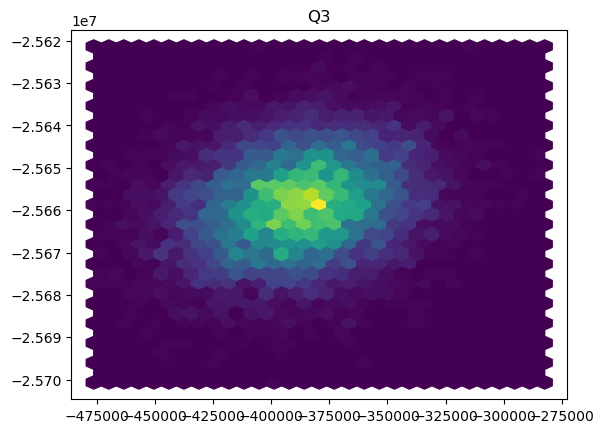

In [12]:
plt.hexbin(s11['3'].real, s11['3'].imag, gridsize=30)
plt.title('Q3')

In [13]:
plt.hexbin(s11['4'].real, s11['4'].imag, gridsize=30)
plt.title('Q1')

KeyError: '4'